# Hotel rating prediction

In [1]:
# import main librariees
import numpy as np 
import pandas as pd 
from IPython.display import clear_output
import os, sys, time, json, re

# set random seed
random_seed = 42

# Graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# nlp processing
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# ML libraries
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics # 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import RandomizedSearchCV
import pickle
import joblib
import optuna
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression

!pip freeze > requirements.txt

In [2]:
#set path
sys.path.insert(1, '../')

from utils.config_reader import config_reader

# Import parameters
config = config_reader('../config/config.json')

# set data folder path
data_dir = config.data_dir

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
df_train = pd.read_csv(data_dir + 'hotels.zip') # train
df_test = pd.read_csv(data_dir+'hotels_test.zip') # test
sample_submission = pd.read_csv(data_dir+'submission.zip') # submission

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [4]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [6]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [7]:
sample_submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [8]:
sample_submission['reviewer_score'].value_counts()

5     13079
10    13021
2     12955
6     12940
8     12887
1     12850
9     12829
3     12825
7     12820
4     12729
Name: reviewer_score, dtype: int64

In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [10]:
# Lets mark train and test data
df_train['sample'] = 1 # train  
df_test['sample'] = 0  # test

# let us create target feature in test data
df_test['reviewer_score'] = 0 # fill with zeros

# join train and test data for prediction
data = df_test.append(df_train, sort=False).reset_index(drop=True) 

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

В признаках  'lat'  'lng' есть пропущенные значения.

In [12]:
# В признаках  'lat' и 'lng' есть пропущенные значения.
#data['lat'] = data['lat'].fillna(0, inplace=True)
#data['lng'] = data['lng'].fillna(0, inplace=True)

In [13]:
# Кол-во уникальных значений
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

## Функции

In [14]:
def get_sort_features(data:pd.DataFrame):
    """Функция определения типа признаков в датафрейме
    Args:
    ------
    data (pd.DataFrame): датафрейм в формате Pandas
    """    
    categorical_columns_names = list() 
    numerical_columns_names = list() 

    for i in data.columns:
        numeric_formats = [np.int16, np.int32, np.int64, np.float16, np.float32, np.float64]  # список числовых типов 'int64' или 'float64'
        if data[i].dtypes in numeric_formats: 
            numerical_columns_names.append(i)
        else:
            categorical_columns_names.append(i)
            
    #print(f'There are {len(categorical_columns_names)} categorical features:')
    
    #for count, value in enumerate(categorical_columns_names, start=1): # list features from 1
       # print(count, value)
    return categorical_columns_names, numerical_columns_names

        
# def get_negative_reasons(arg:str)->str:
#     """Категорирование негативных отзывов

#     Args:
#         arg (str): строка датафрейма

#     Returns:
#         _type_: _description_
#     """    
#     arg = arg.lower().replace(r'\w .+', '').replace('the ', '').replace('was', 'is').replace('were', 'are').replace('too | a bit', '').replace('too', 'is').replace('a bit ', '').replace('a little ', '').replace('very ', '').replace('is is', 'is') 

#     neutral = ['no negative', 'na', 'nothing at all', 'nil', 'n a', 'none', 'none ', 'no complaints', 'no complaints ',\
#         'nothing to dislike', 'nothing really', 'nothing really ', 'can t think of anything', 'absolutely nothing', \
#         'absolutely nothing ', 'nothing not to like', 'nothing to dislike', 'nothing at all', 'nothing at all ', \
#         'nothing to complain about', 'no', 'non', 'not much', 'there is nothing i didn t like', 'nothing in particular', \
#         'nothing comes to mind', 'not applicable', 'there is nothing to dislike', 'not a thing', 'nothing to report', \
#         'weather', 'no thing', 'no negatives']
    
#     unidentified = ['all', 'everything']
    
#     positive = ['i liked everything', 'liked everything', 'nothing it is perfect', 'having to leave', 'leaving', 'all good', 'all is good', 'everything is perfect', ' lovely', 'everything is good', 'everything is great', 'everything is fine', 'nothing everything is perfect' , 'nothing all good', 'as above', 'see above' ]
    
#     service = ['staff', 'service', ]
    
#     room_price = ['price','expensive', 'pricey','cost']
    
#     food_price = ['price of breakfast', 'expensive breakfast', 'breakfast expensive', 'breakfast is expensive', 'breakfast too expensive', 'breakfast not included', 'breakfast is poor' ]
    
#     menu = ['breakfast', 'poor breakfast','breakfast could be better', ]
    
#     room_properties = ['room', 'pillows', 'bathroom', 'size of room', 'room size', 'room is hot', 'room is cold']
    
#     parking = ['no parking', 'parking']
    
#     noise = ['noisy', 'noise', 'loud']
    

#     if arg in positive or ('lovely' or 'no complaints') in arg or 'all good' in arg:         # count positive feedbacks if any
#         return 'positive'

#     elif ('everything' or 'all') and ('great' or 'good' or 'excellent' or 'perfect' or 'fine' or 'lovely') in arg:         # count positive feedbacks if any
#         return 'positive' 
 
           
#     elif arg in neutral or arg==' ' or arg=='nothing ' or arg=='nothing' or 'no complaints' in arg:    # count neutral feedbacks
#         return 'neutral' 

#     elif arg in unidentified:
#         return 'negative' #'unidentified_bad'
    
#     elif arg in room_properties or \
#         ('bed' or 'bathroom' or 'sheets') in arg or \
#         ('room' or 'rooms' or 'bed' or 'beds' or 'bathroom') in arg and ('small' or 'size' or 'big' or 'hot' or 'cold' or 'is tiny') in arg:
        
#         return 'bad_room_properties'
    
#     elif arg in service or 'stuff' in arg:
#         return 'poor_service'
    
#     elif arg in menu or arg=='food':
#         return 'poor_menu'
    
#     elif 'gym' in arg:
#         return 'no_gym'
    
#     elif 'location' in arg:
#         return 'bad_location'
    
#     elif ('wifi' or 'internet') in arg:
#         return 'internet_problems'
    
#     elif arg in noise or ('noise' or 'noisy') in arg:
#         return 'noise'

#     elif arg in room_price:
#         return 'high_room_price'
        
#     elif arg in food_price or 'breakfast' and ('price' or 'expensive' or 'not included' or 'poor') in arg :
#         return 'high_food_price'
    
#     elif arg in parking or 'parking' in arg:
#         return 'poor_parking'
       
#     else:
#         return 'negative' #'other_negative_reasons'   # the rest feedbacks are other
    
    
# def get_positive_reasons(arg):
#     arg = arg.lower().replace(r'\w .+', '').replace('the ', '').replace('was', 'is').replace('were |are very ', 'are').replace('too | a bit', '').replace('is very|is too|is a bit|', 'is').replace(r'gerat|friendly|is excellent|comfy | comfy', 'good').replace('comfy', 'good').replace('is good|is excellent|is perfect', 'good')
    
#     neutral = ['no positive', 'nothing', 'not much']
    
#     location = ['great location', 'good location', 'location is great','excellent location', 'position']
    
#     positive = ['everything', 'everything is perfect', 'all', 'everything is good', 'every thing', 'everything is excellent', 'all good', 'everything is great', 'excellent', 'prefect', 'perfect ','all of it']
    
#     clean = ['clean','cleanliness', 'very clean','clean room' ]

#     room_properties = ['bed', 'nice room']
    
#     if arg in neutral:    # count neutral feedbacks
#        return 'neutral' 

#     elif arg in location or 'location' in arg:  # 
#         return 'positive' #'location'
    
#     elif 'staff' in arg:
#        return 'positive' #'staff'
    
#     elif arg in room_properties or 'bed' in arg or 'room' in arg:
#        return 'positive' #'room_properties'
   
#     elif 'service' or 'staff' in arg:
#        return 'positive' #'service'
    
#     elif 'breakfast' in arg:
#        return 'positive' #'breakfast'
  
#     elif arg in positive:
#         return 'positive' #'positive'
    
#     elif arg in clean:
#         return 'positive' #'clean'
    
#     else:
#         return arg   # the rest are negative feedbacks
    
    
def get_address(arg):
    """Функция вычисления страны и города по адресу
    Args:
    -------
    arg (str): строка с адресом

    Returns:
    -------
    country, city: страна, город (str)
    """    
    arg = arg.split()

    def get_country():
        if arg[-1]=='Kingdom':
            country = arg[-2] + ' '+ arg[-1]
            
        else:
            country = arg[-1]
        return country
    country = get_country()

    def get_city():
        if arg[-1]=='Kingdom':
            city = arg[-5]     
        else:
            city = arg[-2]
        return city
    city = get_city()

    return(country, city)

## Предобработка категориальных признаков

In [15]:
categorical_columns_names, numerical_columns_names = get_sort_features(data)
categorical_columns_names

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review']

### Hotel address

In [16]:
print(data['hotel_address'].value_counts().head(1), data['hotel_address'].value_counts().tail(2))

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom    4789
Name: hotel_address, dtype: int64 13 Rue Fran ois Ory 92120 Paris France                     10
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria     8
Name: hotel_address, dtype: int64


In [17]:
data['country'] = data['hotel_address'].apply(lambda x: \
    (x.split()[-2] + ' '+ x.split()[-1]) if x.split()[-1]=='Kingdom' else  x.split()[-1])

data['city'] = data['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1]=='Kingdom' else  x.split()[-2]) 

print(' ')    
print(data['country'].value_counts(),' ', data['city'].value_counts())
data.drop(['hotel_address'], axis=1, inplace=True)

 
United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: country, dtype: int64   London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64


### Negative reviews

In [18]:
# change feature type
data['negative_review'] = data['negative_review'].astype('object')
data['negative_review'].value_counts().head()

No Negative    127890
 Nothing        14295
 Nothing         4236
 nothing         2225
 N A             1037
Name: negative_review, dtype: int64

In [19]:
# Delete space and lower case
data['negative_review'] = data['negative_review'].apply(lambda x: x.lower() if x=='No Negative' else x.lower()[1:])
data['negative_review'] = data['negative_review'].str.strip()
#data['negative_review'] = data['negative_review'].apply(get_negative_reasons)
#data['negative_review'].value_counts()

In [20]:
def get_neutral_from_negative(arg:str)->str:
    """Categorize neutral feedback from positive

    Args:
        arg (str): DataFrame string

    Returns:
        _str_: either neutral or argument
    """    
    arg = arg.lower().replace(r'\w .+', '').replace('the ', '').replace('was', 'is').replace('were', 'are').replace('too | a bit', '').replace('too', 'is').replace('a bit ', '').replace('a little ', '').replace('very ', '').replace('is is', 'is') 

    neutral = ['no negative', 'na', 'nothing at all', 'nil', 'n a', 'none', 'none ', 'no complaints', 'no complaints ',\
        'nothing to dislike', 'nothing really', 'nothing really ', 'can t think of anything', 'absolutely nothing', \
        'absolutely nothing ', 'nothing not to like', 'nothing to dislike', 'nothing at all', 'nothing at all ', \
        'nothing to complain about', 'no', 'non', 'not much', 'there is nothing i didn t like', 'nothing in particular', \
        'nothing comes to mind', 'not applicable', 'there is nothing to dislike', 'not a thing', 'nothing to report', \
        'weather', 'no thing', 'no negatives']
    

    if arg in neutral or arg==' ' or arg=='nothing ' or arg=='nothing' or 'no complaints' in arg:    # counts neutral feedbacks
        return ' ' 

    else:
        return arg # the rest feedbacks are unchanged

#### Separate neutral feedbacks

In [21]:
# data['clas_neutral_review'] = data['negative_review'].apply(get_neutral_from_negative)
# data['clas_neutral_review'].value_counts().head()

In [22]:
from textblob import Blobber
from textblob.sentiments import NaiveBayesAnalyzer

In [23]:
blobber = Blobber(analyzer=NaiveBayesAnalyzer())
# classification review by NaiveBayesAnalyzer to negative and positive 
data['clas_neg_review'] = data['negative_review'].apply(lambda x: blobber(x).sentiment.classification)
data['clas_pos_review'] = data['positive_review'].apply(lambda x: blobber(x).sentiment.classification)

In [24]:
display(data['clas_neg_review'].value_counts())
print('')
display(data['clas_pos_review'].value_counts())

pos    352195
neg    163543
Name: clas_neg_review, dtype: int64

pos    387969
neg    127769
Name: clas_pos_review, dtype: int64

In [25]:
# Удаляем оригинальный признак 'negative_review'
data.drop(['negative_review'], axis=1, inplace=True)

### Positive reviews

In [26]:
data['positive_review'].value_counts().head()

No Positive    35946
 Location       9222
 Everything     2284
 location       1677
 Nothing        1243
Name: positive_review, dtype: int64

As it can be seen, some rows contain spaces prior to first word. Let us delete it

In [27]:
# Delete space and lower case
data['positive_review'] = data['positive_review'].apply(lambda x: x.lower() if x=='No Positive' else x.lower()[1:])

data['positive_review'] = data['positive_review'].str.strip()
#data['positive_review_encoding'] = data['positive_review'].apply(get_find_reasons)
data['positive_review'].value_counts().head(10)

no positive           35946
location              11945
everything             3314
nothing                1731
great location         1687
the location           1606
good location          1496
breakfast               795
friendly staff          733
excellent location      639
Name: positive_review, dtype: int64

In [28]:
#data['positive_review'] = data['positive_review'].apply(get_positive_reasons)
#data['positive_review'].value_counts().head(10)

# Удаляем оригинальный признак 'positive_review'
data.drop(['positive_review'], axis=1, inplace=True)

### Reviewer nationality

In [29]:
display(data['reviewer_nationality'].value_counts().nlargest(10).index)
display(data['reviewer_nationality'].iloc[0])

Index([' United Kingdom ', ' United States of America ', ' Australia ',
       ' Ireland ', ' United Arab Emirates ', ' Saudi Arabia ',
       ' Netherlands ', ' Switzerland ', ' Germany ', ' Canada '],
      dtype='object')

' United Kingdom '

In [30]:
#Удалим лишние пробелы вначале и вконце строки.
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x[1:-1:1])

#Создадим признак *same nationality*. 
data['nationality_same_as_country'] = data.apply(lambda x: 1 if x['reviewer_nationality'] == x['country'] else 0, axis=1).astype('int16')
data['nationality_same_as_country'].value_counts()

# Оставим 14 наиболее частых национальностей, а остальным присвоим значение 'other'.
most_frequent_nationalities = data['reviewer_nationality'].value_counts().nlargest(14).index.to_list()
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in most_frequent_nationalities else 'other')
data['reviewer_nationality'].value_counts().head()

United Kingdom              245246
other                       120020
United States of America     35437
Australia                    21686
Ireland                      14827
Name: reviewer_nationality, dtype: int64

### Tags

In [31]:
data['tags'].explode().value_counts().nlargest(10)

[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']              5101
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']     4931
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']     4366
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']       3991
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']             3291
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']    3102
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']    2947
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ']                                                  2906
[' Leisure trip ', ' Cou

#### Тип путешественника

In [32]:
def def_traveller(tag:str)->str:
    """Функция извлечения типа путешественника из строки с тегом
    
    """
    try:
        tag_list = tag.split(',')
        traveller_type = tag_list[1]
        traveller_type = re.sub(r'[\']', '', traveller_type)
        traveller_type = re.sub(r'^\s|\s$', '', traveller_type)
        return traveller_type
    
    except IndexError:
        return None

data['traveller_type'] = data['tags'].apply(def_traveller)
data['traveller_type'].value_counts().head()

 Couple                        245754
 Solo traveler                 104060
 Group                          63649
 Family with young children     58573
 Family with older children     25326
Name: traveller_type, dtype: int64

In [33]:
# Оставим 6 самых частых типа, а остальные объединим в 'Other'
popular_travellers_types = data['traveller_type'].value_counts().nlargest(6).index
print(popular_travellers_types)

data['traveller_type'] = data['traveller_type'].apply(lambda x: x if x in popular_travellers_types else ' Other')
data['traveller_type'].value_counts().head()

Index([' Couple', ' Solo traveler', ' Group', ' Family with young children',
       ' Family with older children', ' Travelers with friends'],
      dtype='object')


 Couple                        245754
 Solo traveler                 104060
 Group                          63649
 Family with young children     58573
 Family with older children     25326
Name: traveller_type, dtype: int64

#### Тип путешествия

In [34]:
def def_trip_type(tag:str)->str:
    """Функция извлечения типа путешествия из строки с тегом
    """
    tag_list = tag.split(', ')
    trip_type = tag_list[0]
    
    if 'Leisure trip' in trip_type:
        return 'Leisure trip'
    elif 'Business trip' in trip_type:
        return 'Business trip'
    elif 'Couple' in trip_type:
        return 'Couple'
    elif 'Solo' in trip_type:
        return 'Solo traveler'
    elif 'Family' in trip_type:
        return 'Family'
    elif 'Group' in trip_type:
        return 'Group'
    elif 'pet' in trip_type:
        return 'With a pet'
    elif 'friends' in trip_type:
        return 'Group'
    else:
        return ' Other'

data['trip_type'] = data['tags'].apply(def_trip_type)
data['trip_type'].value_counts().head()

Leisure trip     416672
Business trip     82748
Couple             5808
Solo traveler      4291
Family             3158
Name: trip_type, dtype: int64

#### Длительность отдыха

In [35]:
def get_stay_length(arg:str)->int:
    """Функция определения длительности путешествия
    """
    
    # Ищем числа по шаблону 'Stayed D'
    length = re.findall(r'(?<=Stayed )\d+', arg)
    
    # Проверяем сколько цифр в найденном
    if len(length) == 1:
        return int(length[0])
    else:
        return 0 # если цифр нет, то возвращаем 0

data['stay_length'] = data['tags'].apply(get_stay_length)
data['stay_length'].value_counts().head()

1    193645
2    133937
3     95821
4     47817
5     20845
Name: stay_length, dtype: int64

Text(0.5, -0.2, 'Рис.3 - Распределение длительности отдыха')

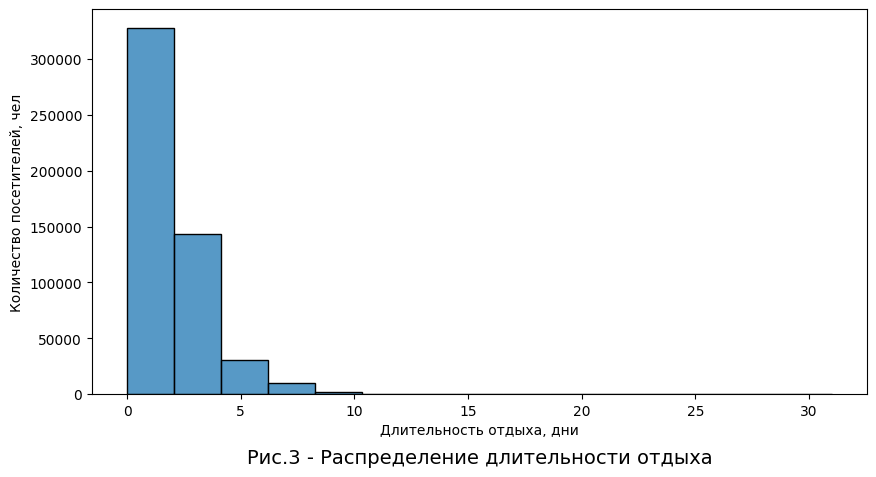

In [36]:
# Отобразим диаграмму распределения длительности отдыха
fig = plt.figure(figsize=(10, 5))

hist = sns.histplot(
    data=data,
    x='stay_length', 
    bins=15,
    #kde=True,
);
hist.set(xlabel='Длительность отдыха, дни', ylabel='Количество посетителей, чел')
hist.set_title('Рис.3 - Распределение длительности отдыха', y=-0.2, fontsize=14)

In [37]:
# Сократим количество уникальных значений до 10
data['stay_length'] = data['stay_length'].apply(lambda x: 10 if x > 9 else x)

#### Тип комнаты

In [38]:
def room_type(tag:str)->str:
    """Функция определения типа комнаты 
    """
    try:
        tag_list = tag.split(',')
        trip_type = tag_list[2]
        trip_type = re.sub(r'[\']', '', trip_type)
        trip_type = re.sub(r'^\s|\s$', '', trip_type)
        return trip_type
    except IndexError:
        return None

data['room_type'] = data['tags'].apply(room_type)
data['room_type'].value_counts().nlargest(15)

 Double Room                     34027
 Standard Double Room            31242
 Superior Double Room            30460
 Deluxe Double Room              24001
 Double or Twin Room             21732
 Standard Double or Twin Room    16978
 Classic Double Room             16553
 Superior Double or Twin Room    13245
 2 rooms                         12054
 Standard Twin Room               9346
 Single Room                      9239
 Twin Room                        7950
 Executive Double Room            6229
 Classic Double or Twin Room      5985
 Deluxe Double or Twin Room       5838
Name: room_type, dtype: int64

In [39]:
def get_room_type(description:str)->str:
    """Функция унификации типов комнат
    """
    description_list = description.split(' ')
    
    if 'Double' in description_list:
        return 'Double Room'
    elif 'Single' in description_list:
        return 'Single Room'
    elif 'Triple' in description_list:
        return 'Triple Room'
    elif 'Family' or 'children' in description_list:
        return 'Family Room'
    elif 'King' or 'Queen' in description_list:
        return 'King Room'
    elif 'Twin' in description_list:
        return 'Twin Room'
    elif 'Apartment' in description_list:
        return 'Apartment'
    elif 'Standard' in description_list:
        return 'Standard Room'
    elif 'Deluxe' in description_list:
        return 'Deluxe Room'
    elif 'Rooms' or 'rooms' in description_list:
        return 'Several Rooms'
    elif 'Suite' in description_list:
        return 'Suite'
    elif 'Stayed' in description_list:
        return 'Other'
    else:
        return description

room_types = data['room_type'].astype('str').apply(get_room_type)
room_types.value_counts().nlargest(15)

Double Room    293654
Family Room    188507
Single Room     24305
Triple Room      9272
Name: room_type, dtype: int64

In [40]:
# Оставим 6 самых частых типов комнат, а остальные назовем 'Others'
popular_room_types = room_types.value_counts().nlargest(6).index
print(popular_room_types)

data['room_type'] = room_types.apply(lambda x: x if x in popular_room_types else 'other')

# Удаляем оригинальный признак 'room_type'
data.drop(['room_type'], axis=1, inplace=True)

Index(['Double Room', 'Family Room', 'Single Room', 'Triple Room'], dtype='object')


In [41]:
# drop feature
data.drop(['tags'], axis=1, inplace=True)

### review_date

In [42]:
# Добавляем признак давности размещения отзыва и месяца
data['review_date'] = pd.to_datetime(data['review_date'], errors='coerce', format='%m/%d/%Y')

# Считаем давность отзыва
data['days_since_review'] = ((data['review_date'].max() - data['review_date'])/np.timedelta64(1,'D')).astype(int)
data['review_month'] = data['review_date'].dt.month.astype(int)
data['review_day'] = data['review_date'].dt.day.astype(int)
data['review_weekday'] = data['review_date'].dt.dayofweek.astype(int)

# Удаляем оригинальный признак
data.drop(['review_date'], axis=1, inplace=True)

## Обработка числовых признаков

### Координаты 'lat' и 'lng'

In [43]:
# Вычислим процент пропусков в среднем по столбцам
cols_null_percent = round(data.isnull().mean() * 100, 2)
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
print(f"Признаки с пропусками, %: \n{cols_with_null}")

Признаки с пропусками, %: 
lat    0.63
lng    0.63
dtype: float64


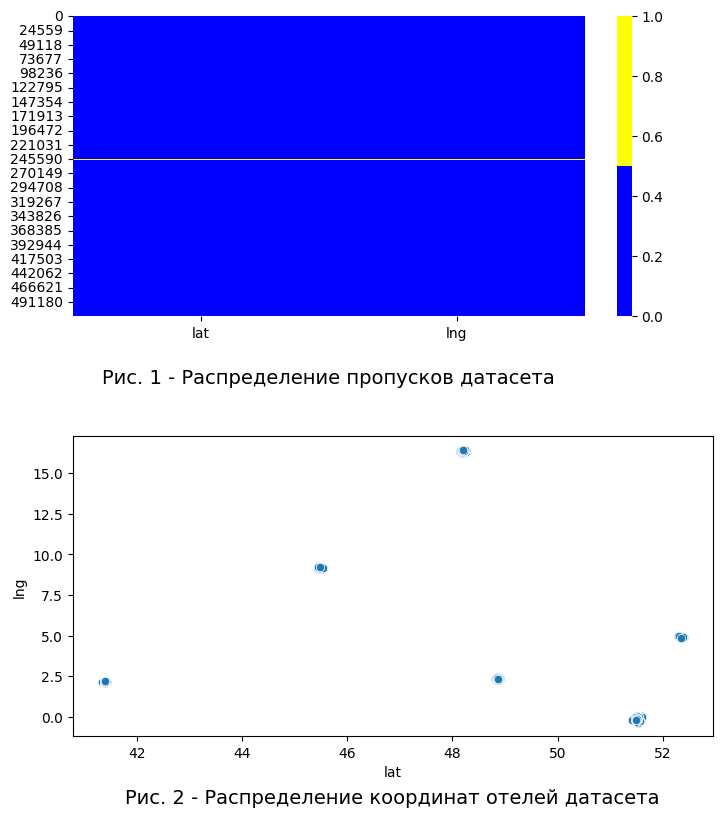

In [44]:
#распространённый способ визуализации пропусков — тепловая карта. 
colors = ['blue', 'yellow'] 
fig, ax = plt.subplots(2, 1, figsize=(8, 9))
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.5,
                    hspace=0.4)

cols = cols_with_null.index
fig_1 = sns.heatmap(
    data[cols].isnull(),
    cmap=sns.color_palette(colors), ax=ax[0]
)
fig_1.set_title('Рис. 1 - Распределение пропусков датасета', y=-0.25, fontsize=14);


# Построим график, на котором отложим координаты 
fig_2 = sns.scatterplot(data=data, x='lat', y='lng', ax=ax[1])
fig_2.set_title('Рис. 2 - Распределение координат отелей датасета', y=-0.25, fontsize=14);

In [45]:
# Определение записей содержаших пропуски
null_addresses = list(set(data[data['lat'].isnull()]['city']))

null_cities = list()
for x in null_addresses:
    null_cities.append(x) 
    
# Список уникальных городов
distinct_cities=list(set(null_cities))

display(f'Количество строк с названиями городов, в которых обнаружены пропуски: {len(null_cities)}')
display(f'Количество уникальных названий городов: {len(set(null_cities))}. Это: {distinct_cities}')

'Количество строк с названиями городов, в которых обнаружены пропуски: 3'

"Количество уникальных названий городов: 3. Это: ['Vienna', 'Barcelona', 'Paris']"

Пропусков мало и их можно устранить, взяв координаты цетров одноименных городов из результатов поиска гуглом.

In [46]:
# Координаты центров городов
city_center_coordinates = {
    'Vienna': [48.210033, 16.363449],
    'Barcelona': [41.390205, 2.154007],
    'Paris': [48.864716, 2.349014]
}

lat_mask = data['lat'].isnull()
lng_mask = data['lng'].isnull()

for city, coordinates in city_center_coordinates.items():
    data.loc[(lat_mask & (data['city'] == city)), 'lat'] = coordinates[0]
    data.loc[(lng_mask & (data['city'] == city)), 'lng'] = coordinates[1]
    
#Проверка отсутствия пропущенных значений (доля пропусков)
display(data.isnull().mean().head())

additional_number_of_scoring         0.0
average_score                        0.0
hotel_name                           0.0
reviewer_nationality                 0.0
review_total_negative_word_counts    0.0
dtype: float64

## Нормализация числовых признаков, кроме: 'sample', 'lng', 'lat'

In [47]:
categorical_columns_names, numerical_columns_names = get_sort_features(data)
#numerical_columns_names

for i in ['lat', 'lng', 'sample', 'reviewer_score', 'review_month', 'review_day', 'review_weekday', 'nationality_same_as_country']: #
    numerical_columns_names.remove(i)
numerical_columns_names

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'stay_length']

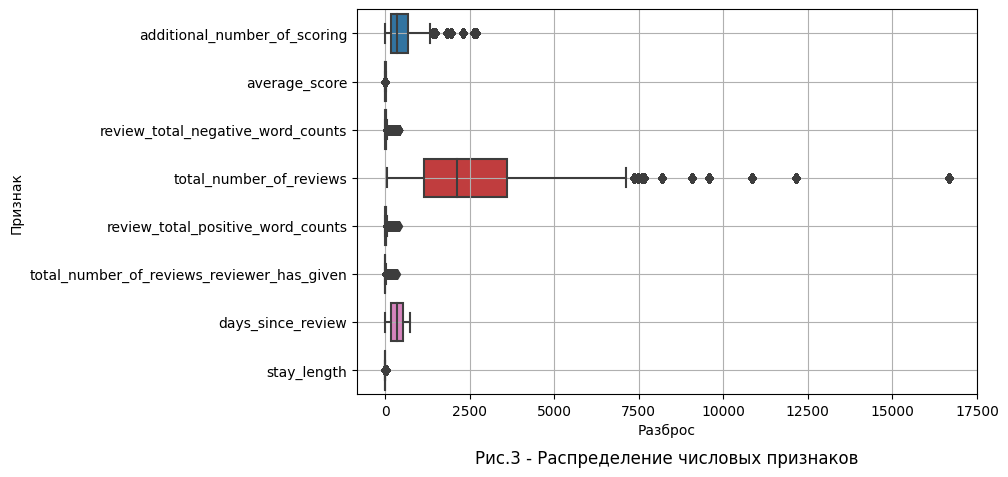

In [48]:
fig = plt.figure(figsize=(8, 5))

boxplot = sns.boxplot(data=data[numerical_columns_names], orient='h')
boxplot.set_title('Рис.3 - Распределение числовых признаков', y=-0.2, fontsize=12)
boxplot.set_xlabel('Разброс')
boxplot.set_ylabel('Признак')
boxplot.grid();

In [49]:
data[numerical_columns_names].agg(['min','mean', 'max']).round(2).T

,min,mean,max
additional_number_of_scoring,1.0,498.08,2682.0
average_score,5.2,8.40,9.8
review_total_negative_word_counts,0.0,18.54,408.0
total_number_of_reviews,43.0,2743.74,16670.0
review_total_positive_word_counts,0.0,17.78,395.0
total_number_of_reviews_reviewer_has_given,1.0,7.17,355.0
days_since_review,0.0,354.44,730.0
stay_length,0.0,2.35,10.0


Обработка в 2 этапа.

1 этап

In [50]:
# How many unique values contain features
print('Unique values in features:')
for col in data[numerical_columns_names].columns.tolist()[:24]:
    print(f'{col}: {data[col].nunique()}')

Unique values in features:
additional_number_of_scoring: 480
average_score: 34
review_total_negative_word_counts: 402
total_number_of_reviews: 1142
review_total_positive_word_counts: 365
total_number_of_reviews_reviewer_has_given: 198
days_since_review: 731
stay_length: 11


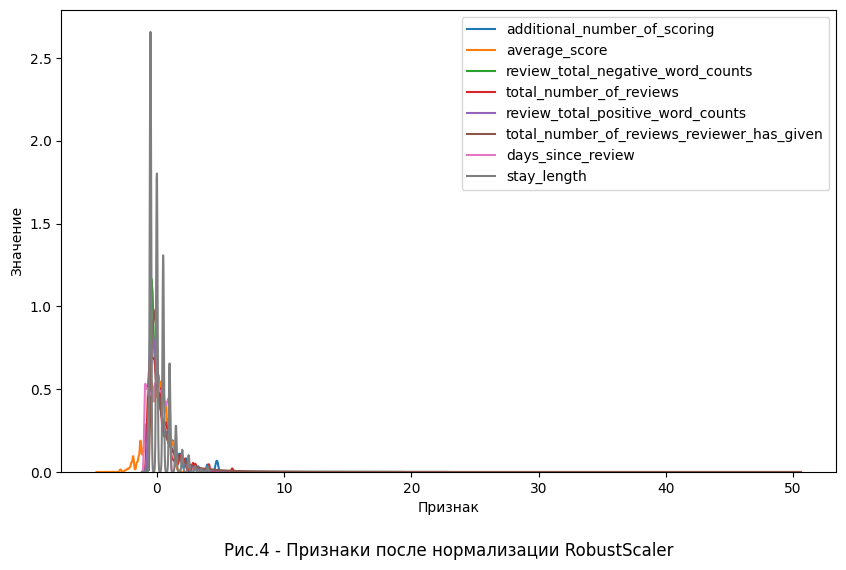

In [51]:
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# копируем датасет
data_norm = data[numerical_columns_names].copy() #

# преобразуем
data_norm_rs = r_scaler.fit_transform(data_norm)

# создаем датафрейм
data_norm_rs = pd.DataFrame(data_norm_rs, columns=numerical_columns_names)

# Визуализация
fig, ax = plt.subplots(ncols=1, figsize=(10, 6))

for col in numerical_columns_names:
    sns.kdeplot(data_norm_rs[col], ax=ax)
    
ax.set_title('Рис.4 - Признаки после нормализации RobustScaler', y=-0.2, fontsize=12)
ax.legend(numerical_columns_names)
ax.set_xlabel('Признак')
ax.set_ylabel('Значение');

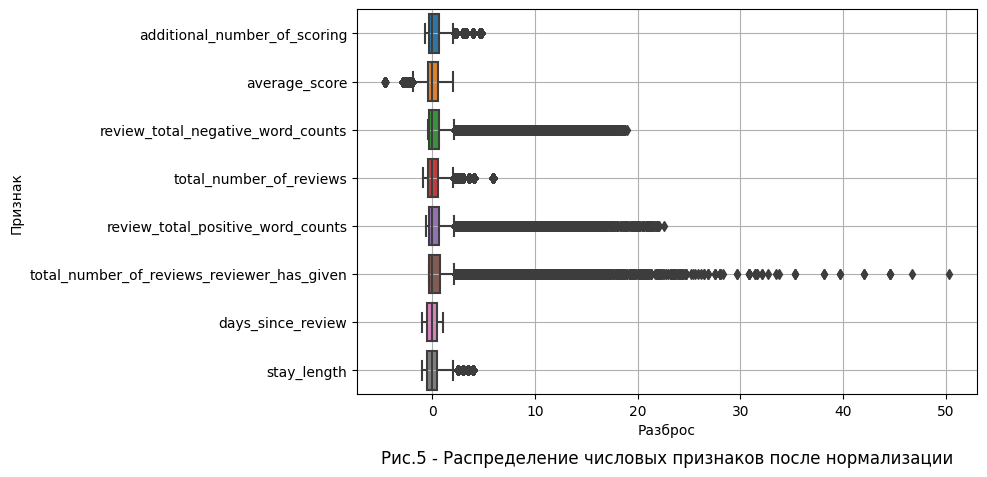

In [52]:
#categorical_columns_names, numerical_columns_names = get_sort_features(data)

fig = plt.figure(figsize=(8, 5))

boxplot = sns.boxplot(data=data_norm_rs, orient='h')
boxplot.set_title('Рис.5 - Распределение числовых признаков после нормализации', y=-0.2, fontsize=12)
boxplot.set_xlabel('Разброс')
boxplot.set_ylabel('Признак')
boxplot.grid();

Join transformed features to the dataFrame

In [53]:
data.drop(numerical_columns_names, axis=1, inplace=True)
data = data.join(data_norm_rs)
data.head(2)

,hotel_name,reviewer_nationality,lat,lng,sample,reviewer_score,country,city,clas_neg_review,clas_pos_review,...,review_day,review_weekday,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,stay_length
0,Hotel Da Vinci,United Kingdom,45.533137,9.171102,0,0.0,Italy,Milan,pos,pos,...,21,4,1.146640,-0.428571,2.047619,5.928222,3.000000,-0.285714,-0.965909,0.0
1,Urban Lodge Hotel,Belgium,52.385649,4.834443,0,0.0,Netherlands,Amsterdam,neg,neg,...,12,0,0.551935,0.285714,0.047619,1.176183,-0.647059,0.571429,-0.338068,-0.5


## Кодировка категориальных признаков 

In [54]:
#data.info()

In [55]:
# Удаляем признаки, которые не будем использовать
data.drop(['hotel_name'], axis=1, inplace=True)

In [56]:
data = pd.get_dummies(data) #, columns=categorical_columns_names
data.columns

Index(['lat', 'lng', 'sample', 'reviewer_score', 'nationality_same_as_country',
       'review_month', 'review_day', 'review_weekday',
       'additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'stay_length', 'reviewer_nationality_Australia',
       'reviewer_nationality_Belgium', 'reviewer_nationality_Canada',
       'reviewer_nationality_France', 'reviewer_nationality_Germany',
       'reviewer_nationality_Ireland', 'reviewer_nationality_Israel',
       'reviewer_nationality_Italy', 'reviewer_nationality_Netherlands',
       'reviewer_nationality_Saudi Arabia', 'reviewer_nationality_Switzerland',
       'reviewer_nationality_United Arab Emirates',
       'reviewer_nationality_United Kingdom',
       'reviewer_nationality_United States of America',
       'reviewer_nationality_other', 'country_A

## Проверка на мультиколлинеарность

In [57]:
# чтобы исключить мультиколлениарность удалим признаки, сильно коррелирующий с другим признаком
# Отберем признаки, корреляция между которыми превышает 0,7
pivot = data.corr()
pivot = pivot.drop('sample', axis=0)
pivot = pivot.drop('sample', axis=1)

for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.7 or x == 1) else x)
    
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')

high_correlation_features = list(pivot.columns) # список признаков c высокой корреляцией
pivot 

print('Признаки с подозрением на мультиколлинеарность')
for count, value in enumerate(high_correlation_features, start=1): # list features from 1
    print(count, value)

Признаки с подозрением на мультиколлинеарность
1 lat
2 lng
3 nationality_same_as_country
4 additional_number_of_scoring
5 total_number_of_reviews
6 reviewer_nationality_United Kingdom
7 country_Austria
8 country_Spain
9 city_Barcelona
10 city_Vienna
11 clas_neg_review_neg
12 clas_neg_review_pos
13 clas_pos_review_neg
14 clas_pos_review_pos
15 trip_type_Business trip
16 trip_type_Leisure trip


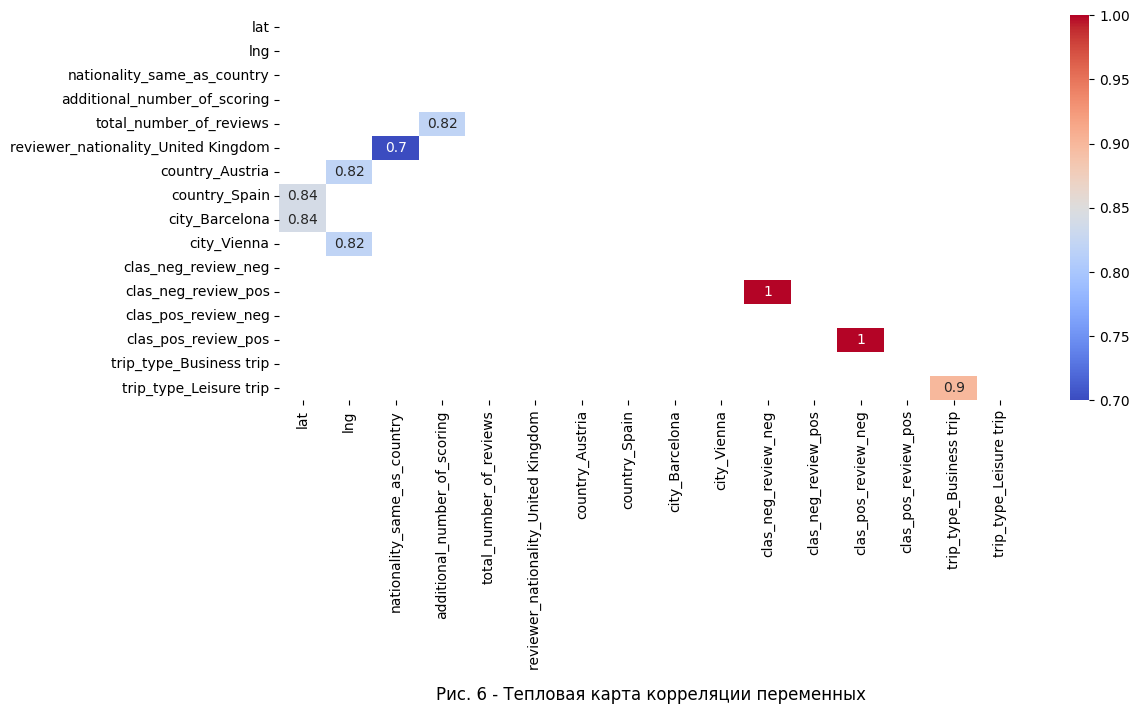

In [58]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 5))

matrix = np.triu(pivot)  
fig = sns.heatmap(round(abs(pivot),2), annot=True,  cmap= 'coolwarm', mask=matrix) #, vmin=-1, vmax=1, center= 0, fmt='.02g',
ax.set_title('Рис. 6 - Тепловая карта корреляции переменных', y=-0.8, fontsize=12)
ax.tick_params(axis='x', rotation=90);

In [59]:
# Удаляем признаки с максимальной корреляцией
counter = 0
for lower_bound in np.linspace(0.98, 0.7, num=14):
    for col in pivot:
        if pivot[col].max() > lower_bound or pivot[col].min() < -lower_bound:
            #pivot = pivot.drop(col, axis=0)
            pivot = pivot.drop(col, axis=1)
            #data = data.drop(col, axis=1)
            counter += 1
            
print('Deleted', counter, 'columns')

Deleted 16 columns


In [60]:
# fig, ax = plt.subplots(ncols=1, figsize=(30, 25))

# matrix = np.triu(data.corr())  
# fig = sns.heatmap(round(abs(data.corr()),2), annot=True,  cmap= 'coolwarm', mask=matrix) #, vmin=-1, vmax=1, center= 0, fmt='.02g',
# ax.set_title('Рис. 6 - Тепловая карта корреляции переменных', y=-0.15, fontsize=12);

In [61]:
data['sample']

0         0
1         0
2         0
3         0
4         0
         ..
515733    1
515734    1
515735    1
515736    1
515737    1
Name: sample, Length: 515738, dtype: int64

## Модель

#### Проверяем остались ли признаки типа object

In [62]:
data.dtypes.value_counts()

# Если остались признаки с dtypes "object", то модель обучаться не будет. Их нужно удалить
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [63]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)


X = train_data.drop(['reviewer_score'], axis=1)
y = train_data['reviewer_score'].values            # наш таргет

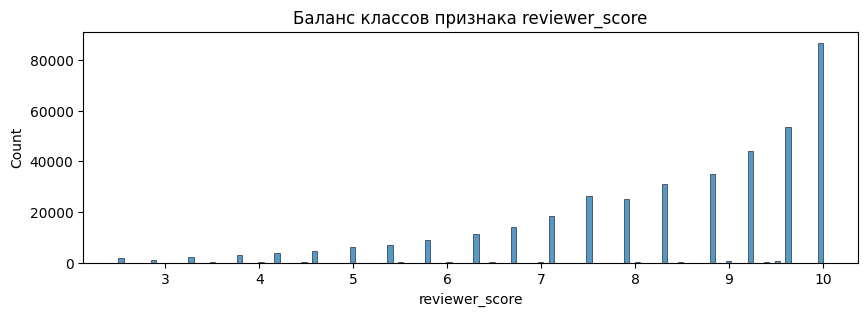

In [64]:
#display(train_data['reviewer_score'].value_counts(normalize=True))

fig, ax = plt.subplots(figsize = (10, 3))
ax = sns.histplot(data=train_data, x='reviewer_score')
#Задаем название графику
ax.set_title('Баланс классов признака reviewer_score');

In [65]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_seed)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_test, X_valid, y_test, y_valid  = train_test_split(X_valid, y_valid, test_size=0.5, random_state=random_seed)

In [66]:
# проверяем
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape:  {}'.format(X_test.shape))

Train shape: (309442, 59)
Valid shape: (38681, 59)
Test shape:  (38680, 59)


### Модель 1. Random forest

In [67]:
model_rf = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=random_seed)

#Train model
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

print(' MAE: {:.2}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print(f"MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_pred)*100, 2)} %")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


 MAE: 0.92
MAPE: 13.33 %


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.3s finished


In [64]:
# # в RandomForestRegressor есть возможность вывести самые важные признаки для модели
# plt.rcParams['figure.figsize'] = (6,6)
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(15).plot(kind='barh')

#### Save model 

Saved model is about 320 Mb and it seems to be not needed 

In [87]:
# # Save model to the given path in the pkl format
# model_path = config.model_path
# full_path = os.path.join(model_path, 'model_rf.pkl')

# # with open(full_path, 'wb') as f:
# #     pickle.dump(model_rf, f)

# with open(full_path, 'wb') as f:
#     joblib.dump(model_rf, f, compress=5)

### Модель 2. Random forest + cross validation

In [65]:
# % time
# param_distributions = {
#     'n_estimators': list(range(400, 500, 100)),
#     #'criterion': ['squared_error', 'absolute_error'],
#     #'max_depth': list(np.linspace(5, 45, 15, dtype=int)),
#     #'min_samples_leaf': list(range(3, 12, 3)),
#     "bootstrap":[True]
# }
            
# random_search_forest = RandomizedSearchCV(
#     estimator=ensemble.RandomForestRegressor(random_state=random_seed), 
#     param_distributions=param_distributions, 
#     cv=5,
#     n_iter = 5, 
#     n_jobs = -1
# )  

# random_search_forest.fit(X_train, y_train) 

# y_train_pred = random_search_forest.predict(X_train)
# y_test_pred = random_search_forest.predict(X_test)
# print('f1_score for validation sample: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
# print("Best hyperparameters are: {}".format(random_search_forest.best_params_))

# # save best parameters to a new dict
# best_params_rf = random_search_forest.best_params_

### Model 3. Random forest + optuna

In [76]:
# def optuna_rf(trial):
#     # hyperparameters range
#     n_estimators = trial.suggest_int('n_estimators', 400, 500, 100)
#     #max_depth = trial.suggest_int('max_depth', 30, 50, 10)
#     #min_samples_leaf = trial.suggest_int('min_samples_leaf', 4, 12, 3)
    
#     # create the model
#     model = ensemble.RandomForestRegressor(
#         n_estimators=n_estimators,
#         #max_depth=max_depth,
#         #min_samples_leaf=min_samples_leaf,
#         #criterion=criterion,
#         random_state=random_seed
#     )
    
#     # train model
#     model.fit(X_train, y_train)
#     score = metrics.mean_absolute_error(y_train, model.predict(X_train)).round(4)

#     return score

In [ ]:
# %%time

# # Creation of an instance of optuna class
# study = optuna.create_study(study_name="RandomForestRegressor", direction="minimize")

# # tyr to find best hyperparameters n_trials times
# study.optimize(optuna_rf, n_trials=2)

# #clear_output(wait=False)

# # Display optimized hyperparameters by optuna
# print("Best hyperparameters {}".format(study.best_params))
# print("Best MAE: {:.2f}".format(study.best_value))
# best_params_opt = study.best_params

In [ ]:
#optuna.visualization.plot_optimization_history(study, target_name="f1_score")

## Model 4. Stacking

In [68]:
# Initiate estimators
estimators = [
    ('linear', LinearRegression()),
    ('dt',  RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=random_seed))
]

# Create an instance of the stacking class
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(
        n_estimators=100,
        random_state=random_seed)
)
#Обучаем модель
reg.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   58.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   59.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n

StackingRegressor(estimators=[('linear', LinearRegression()),
                              ('dt',
                               RandomForestRegressor(n_jobs=-1, random_state=42,
                                                     verbose=1))],
                  final_estimator=RandomForestRegressor(random_state=42))

In [69]:
y_pred = reg.predict(X_test)

print(' MAE: {:.2}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print(f"MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_pred)*100, 2)} %")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.3s finished


 MAE: 0.99
MAPE: 14.25 %


## Stacking

In [72]:
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor

In [73]:
estimators2 = [
    ('lr', RidgeCV()),
    ('dt',  DecisionTreeRegressor(random_state=42))
]

# Create an instance of the stacking class
model_stacking = StackingRegressor(
    estimators=estimators2,
    final_estimator=RandomForestRegressor(
        n_estimators=100,
        random_state=random_seed)
)
#Обучаем модель
model_stacking.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', RidgeCV()),
                              ('dt', DecisionTreeRegressor(random_state=42))],
                  final_estimator=RandomForestRegressor(random_state=42))

In [75]:
y_pred = model_stacking.predict(X_test)

print(' MAE: {:.2}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print(f"MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_pred)*100, 2)} %")

 MAE: 1.1
MAPE: 15.75 %


# Submission

In [88]:
test_data.sample(10)

,lat,lng,reviewer_score,nationality_same_as_country,review_month,review_day,review_weekday,additional_number_of_scoring,average_score,review_total_negative_word_counts,...,traveller_type_ Other,traveller_type_ Solo traveler,traveller_type_ Travelers with friends,trip_type_Business trip,trip_type_Couple,trip_type_Family,trip_type_Group,trip_type_Leisure trip,trip_type_Solo traveler,trip_type_With a pet
60809,51.501233,-0.185994,0.0,1,3,22,1,-0.380855,-0.285714,-0.238095,...,0,0,0,0,0,0,0,1,0,0
42817,51.508404,-0.106799,0.0,0,1,11,0,1.545825,1.000000,-0.333333,...,0,1,0,1,0,0,0,0,0,0
10633,51.500961,-0.116591,0.0,0,4,19,1,4.647658,0.428571,-0.285714,...,0,1,0,0,0,0,0,1,0,0
37721,51.507271,-0.021121,0.0,1,10,30,6,1.199593,0.714286,-0.428571,...,0,0,0,0,0,0,0,1,0,0
110358,51.493873,-0.182496,0.0,1,6,15,2,0.380855,0.428571,-0.428571,...,0,0,0,0,0,0,0,1,0,0
44246,41.383354,2.179404,0.0,0,6,5,6,-0.334012,-0.714286,-0.428571,...,0,0,0,0,0,0,0,1,0,0
119815,41.381257,2.126908,0.0,0,12,19,5,-0.468432,-0.428571,2.333333,...,0,0,0,1,0,0,0,0,0,0
128743,48.843052,2.342252,0.0,0,11,19,5,-0.570265,0.428571,-0.428571,...,0,0,0,0,0,0,0,1,0,0
34296,51.521807,-0.085608,0.0,0,12,15,3,0.244399,1.142857,-0.428571,...,1,0,0,0,0,0,0,0,0,1
43140,52.354665,4.913164,0.0,0,7,31,6,1.291242,0.428571,-0.190476,...,0,1,0,0,0,0,0,1,0,0


In [89]:
test_data = test_data.drop(['reviewer_score'], axis=1)
test_data.head()

In [90]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [104]:
predict_submission = model_rf.predict(test_data)
predict_submission

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.2s finished


array([8.659, 6.762, 8.429, ..., 7.721, 9.624, 7.031])

In [106]:
predict_submission = np.round(predict_submission, 1)
predict_submission

array([8.7, 6.8, 8.4, ..., 7.7, 9.6, 7. ])

In [107]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission_alex_1.csv', index=False)
sample_submission.head(2)

,reviewer_score,id
0,8.7,488440
1,6.8,274649


## K-fold method (cross validation)

In [101]:
from sklearn.model_selection import KFold, cross_validate #методы разделения и валидации

In [109]:
#Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
 
#Создаём объект кросс-валидатора KFold
kf = KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring=('neg_mean_absolute_error','neg_mean_absolute_percentage_error'), #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

ValueError: 'mean_absolute_error' is not a valid scoring value. Use sklearn.metrics.get_scorer_names() to get valid options.

In [106]:
cv_metrics.keys()

dict_keys(['fit_time', 'score_time', 'test_neg_mean_absolute_error', 'train_neg_mean_absolute_error', 'test_neg_mean_absolute_percentage_error', 'train_neg_mean_absolute_percentage_error'])

In [110]:
# Lets study metrics

print('Train k-fold MAE: {:.2f}  MAPE: {:.4f}'.format(
    np.mean(cv_metrics['train_neg_mean_absolute_error']), 
    np.mean(cv_metrics['train_neg_mean_absolute_percentage_error'])))
print('Test k-fold MAE: {:.2f}  MAPE: {:.4f}'.format(
    np.mean(cv_metrics['test_neg_mean_absolute_error']), 
    np.mean(cv_metrics['test_neg_mean_absolute_percentage_error'])))

Train k-fold MAE: -0.34  MAPE: -0.0491
Test k-fold MAE: -0.91  MAPE: -0.1325


In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.2s finished
